<a href="https://colab.research.google.com/github/nbisso/TP2-Orga-7506/blob/main/prueba_con_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
!pip install --upgrade category_encoders
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
import category_encoders as ce
import xgboost as xgb
import datetime
import pytz

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Levanto la data de los DFS

In [8]:
train_labels = pd.read_csv('/content/drive/MyDrive/datasets_tp2/train_labels.csv')
train_values = pd.read_csv('/content/drive/MyDrive/datasets_tp2/train_values.csv')
df_test = pd.read_csv('/content/drive/MyDrive/datasets_tp2/test_values.csv')

In [88]:
train_labels

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
...,...,...
260596,688636,2
260597,669485,3
260598,602512,3
260599,151409,2


In [87]:
train_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260597,669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260598,602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260599,151409,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [86]:
df_test

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0
86864,663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
86865,1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
86866,442785,6,1041,912,2,5,9,5,t,r,n,f,q,s,d,1,1,0,0,0,0,0,0,0,0,0,a,1,0,0,0,0,0,0,0,0,0,0,0


Feature Engineering

Usamos BinaryEncoder de los categoricos

In [92]:
encoder= ce.BinaryEncoder(cols= ['land_surface_condition', 'foundation_type', \
                                 'roof_type', 'ground_floor_type', 'other_floor_type',\
                                 'position', 'plan_configuration', 'legal_ownership_status'], return_df = True)

df_train_encoding = encoder.fit_transform(train_values)
df_test_encoding = encoder.fit_transform(df_test)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [93]:
df_train_encoding

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition_0,land_surface_condition_1,land_surface_condition_2,foundation_type_0,foundation_type_1,foundation_type_2,foundation_type_3,roof_type_0,roof_type_1,roof_type_2,ground_floor_type_0,ground_floor_type_1,ground_floor_type_2,ground_floor_type_3,other_floor_type_0,other_floor_type_1,other_floor_type_2,position_0,position_1,position_2,plan_configuration_0,plan_configuration_1,plan_configuration_2,plan_configuration_3,plan_configuration_4,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status_0,legal_ownership_status_1,legal_ownership_status_2,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
260597,669485,17,715,2060,2,0,6,5,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
260598,602512,17,51,8163,3,55,6,7,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
260599,151409,26,39,1851,2,10,14,6,0,0,1,0,0,0,1,0,1,1,0,0,1,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [94]:
df_test_encoding

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition_0,land_surface_condition_1,land_surface_condition_2,foundation_type_0,foundation_type_1,foundation_type_2,foundation_type_3,roof_type_0,roof_type_1,roof_type_2,ground_floor_type_0,ground_floor_type_1,ground_floor_type_2,ground_floor_type_3,other_floor_type_0,other_floor_type_1,other_floor_type_2,position_0,position_1,position_2,plan_configuration_0,plan_configuration_1,plan_configuration_2,plan_configuration_3,plan_configuration_4,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status_0,legal_ownership_status_1,legal_ownership_status_2,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0
86864,663567,10,1407,11907,3,25,6,7,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
86865,1049160,22,1136,7712,1,50,3,3,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
86866,442785,6,1041,912,2,5,9,5,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


Armamos y entrenamos el modelo XGBOOST

In [95]:
df_test_encoding = df_test_encoding.iloc[:,1:]
X = df_train_encoding.iloc[:, 1:]
y = train_labels.iloc[:, 1:]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [97]:
xgb_cl = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, 
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1,
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [98]:
# param_grid = {
#     "max_depth": [3, 4, 5, 7],
#     "learning_rate": [0.1, 0.01, 0.05],
#     "gamma": [0, 0.25, 1],
#     "reg_lambda": [0, 1, 10],
#     "scale_pos_weight": [1, 3, 5],
#     "subsample": [0.8],
#     "colsample_bytree": [0.5],
# }

# grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3)


# _ = grid_cv.fit(X_test,y_test)
xgb_cl.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=4, nthread=None, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=1)

hago el predict de los valores de test

In [99]:
pred_xgboost = xgb_cl.predict(X_test)

In [100]:
f1_score(y_test, pred_xgboost, average ='micro')

0.6919667696322019

<BarContainer object of 58 artists>

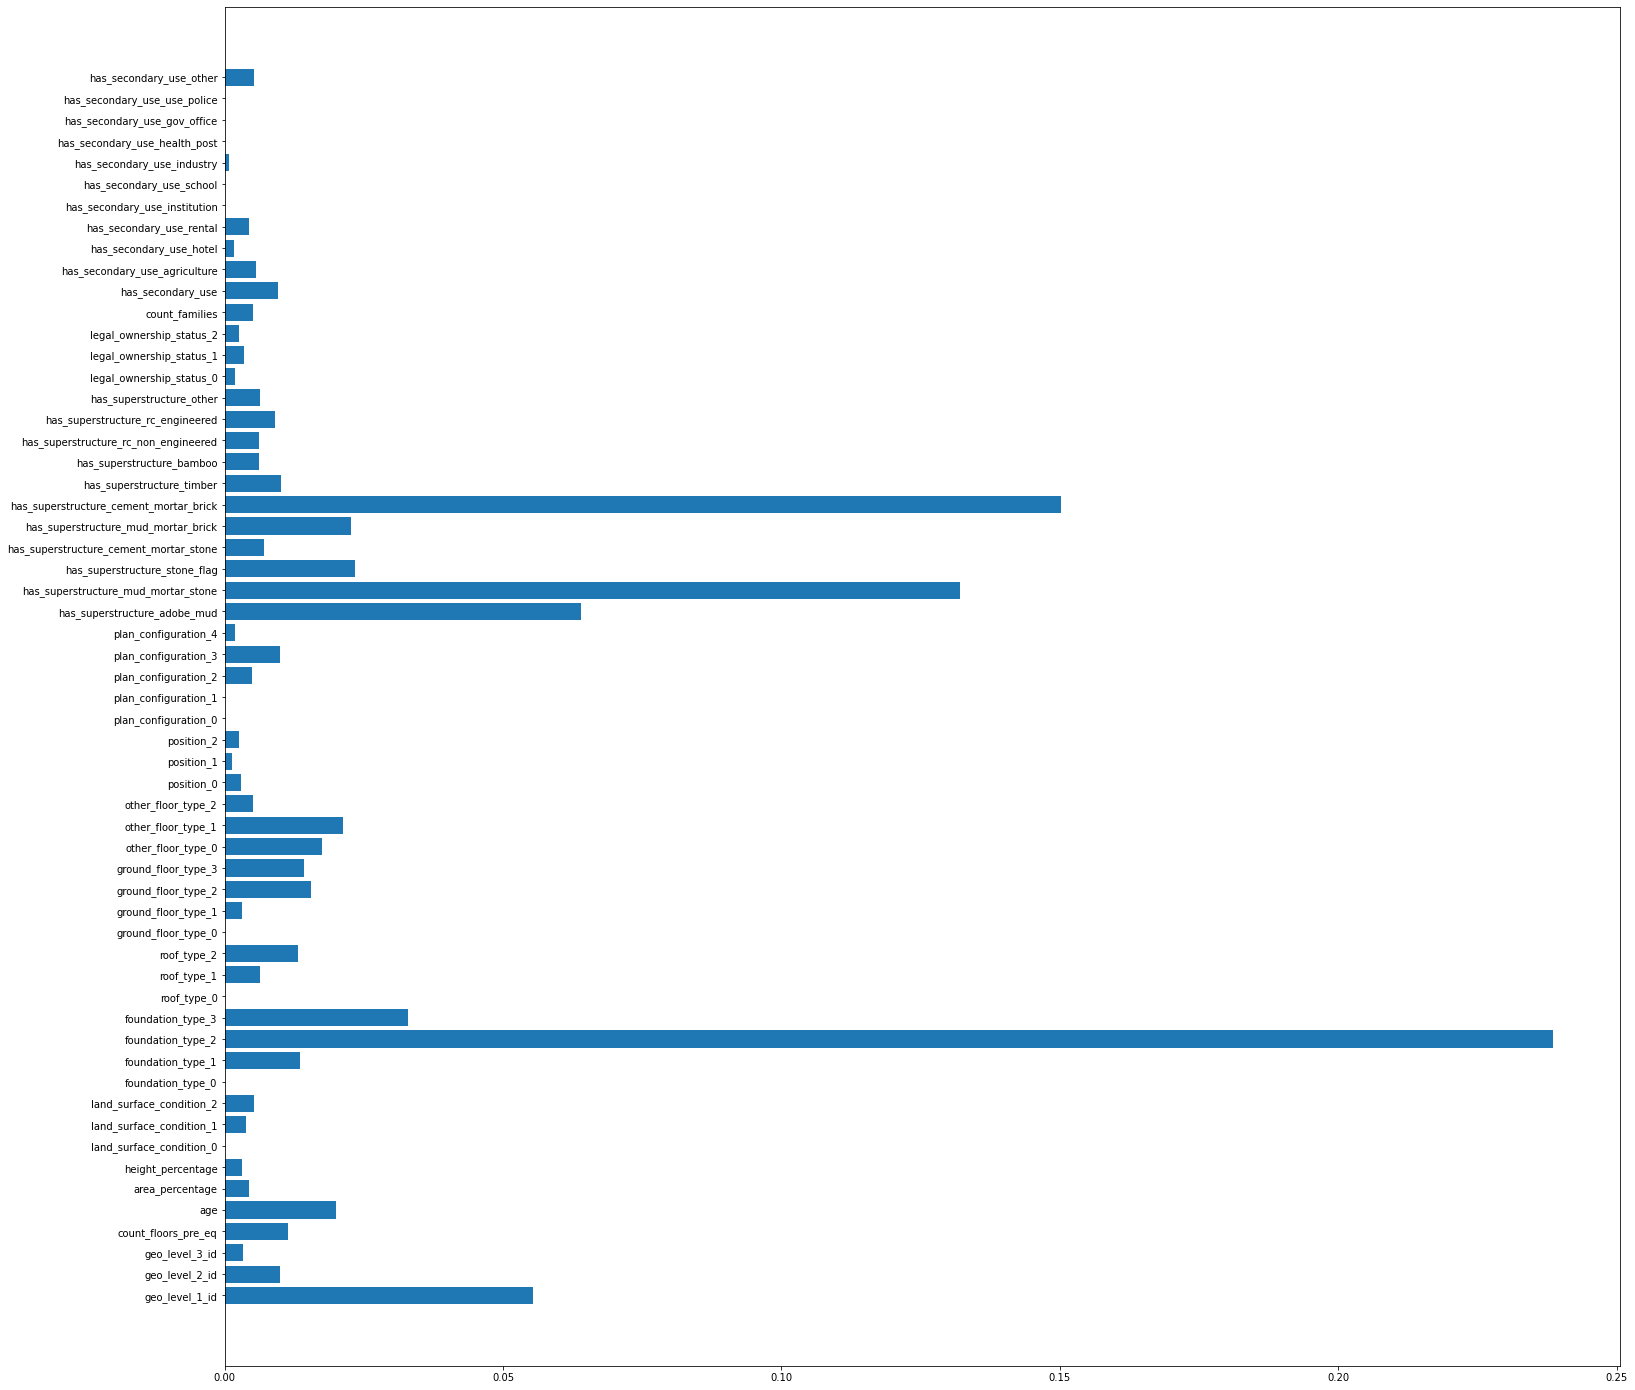

In [101]:
plt.figure(figsize=(25,25))
plt.barh(X.columns, xgb_cl.feature_importances_)


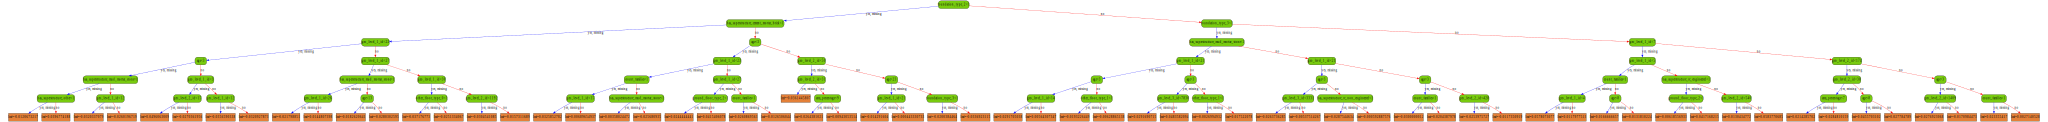

In [102]:
node_params = {'shape' : 'box',
              'style': 'filled, rounded',
               'fillcolor' : '#78cbe'}

leaf_params = {'shape' : 'box',
              'style': 'filled',
               'fillcolor' : '#e48038'}

xgb.to_graphviz(xgb_cl,num_trees=0,size="60,60",condition_node_params=node_params,leaf_node_params=leaf_params)

predigo el df_test y creo el file contra el format csv

In [103]:
pred_xgboost_final = xgb_cl.predict(df_test_encoding)


In [104]:
pred_xgboost_final

array([3, 2, 2, ..., 2, 2, 2])

In [105]:
submission_format = pd.read_csv('/content/drive/MyDrive/datasets_tp2/submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=pred_xgboost_final,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [115]:
fecha = datetime.datetime.now(pytz.timezone("Etc/GMT+3"))
my_submission.to_csv('/content/drive/MyDrive/datasets_tp2/' + fecha.strftime("%d%b%Y %H:%M") +'_training-result.csv',index= True)